In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Assignment.zip

Archive:  /content/drive/MyDrive/Assignment.zip
   creating: Assignment/Adaboost/
  inflating: Assignment/Adaboost/adaboost_acc_scores.jpg  
  inflating: Assignment/Adaboost/adaboost_all_dim.ipynb  
  inflating: Assignment/Adaboost/adaboost_all_dim.pkl  
  inflating: Assignment/Adaboost/adaboost_auc_scores.jpg  
  inflating: Assignment/Adaboost/adaboost_PCA.ipynb  
  inflating: Assignment/Adaboost/adaboost_PCA.pkl  
  inflating: Assignment/Adaboost/pca_adaboost_results.csv  
  inflating: Assignment/autoencoder.ipynb  
  inflating: Assignment/comaprison.ipynb  
   creating: Assignment/Data/
  inflating: Assignment/Data/encoder_model.pkl  
  inflating: Assignment/Data/label - Copy.csv  
  inflating: Assignment/Data/label.csv  
  inflating: Assignment/Data/merged.csv  
  inflating: Assignment/Data/merged_standardized.csv  
  inflating: Assignment/Data/mRNA.csv  
  inflating: Assignment/Data/syn_X.pkl  
  inflating: Assignment/Data/syn_y.pkl  
  inflating: Assignment/Data/test_df.csv  
  i

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle

In [4]:
X_train = pickle.load(open('/content/Assignment/Data/X_train.pkl', 'rb'))
y_train = pickle.load(open('/content/Assignment/Data/y_train.pkl', 'rb'))
X_test = pickle.load(open('/content/Assignment/Data/X_test.pkl', 'rb'))
y_test = pickle.load(open('/content/Assignment/Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(329, 20530)
(329,)
(83, 20530)
(83,)


In [5]:
# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)

[[-0.48855657  0.12112708 -0.33372349 ...  0.04735987  0.50779996
  -0.02217494]
 [ 0.83092164  1.17948768 -0.33372349 ...  0.18754437  0.77965228
  -0.17205193]
 [-1.861054   -0.69352094 -0.33372349 ... -0.35346398 -2.00005787
   3.63814136]
 ...
 [ 1.50287947  0.88173571  0.1048791  ... -0.33180584  0.91213697
  -0.14253948]
 [-0.06583194  0.60359346 -0.33372349 ...  0.20030191  0.44110666
  -1.31512921]
 [-0.87784052 -0.01478846 -0.33372349 ...  0.12805867  1.46177518
  -0.6430939 ]]


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([329, 20530]),
 torch.Size([83, 20530]),
 torch.Size([329]),
 torch.Size([83]))

In [8]:
# define an autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(256, encoding_dim),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(1024, input_dim),
            nn.ReLU(True)
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

In [9]:
encoder = Autoencoder(input_dim=20530, encoding_dim=64)
encoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20530, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
 

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

# train the autoencoder
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):

        inputs = X_train[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = encoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.item()))

epoch [1/1000], loss:1.1349
epoch [2/1000], loss:1.1058
epoch [3/1000], loss:1.0857
epoch [4/1000], loss:1.0707
epoch [5/1000], loss:1.0546
epoch [6/1000], loss:1.0490
epoch [7/1000], loss:1.0364
epoch [8/1000], loss:1.0231
epoch [9/1000], loss:1.0177
epoch [10/1000], loss:1.0073
epoch [11/1000], loss:1.0079
epoch [12/1000], loss:1.0005
epoch [13/1000], loss:0.9944
epoch [14/1000], loss:0.9752
epoch [15/1000], loss:0.9709
epoch [16/1000], loss:0.9679
epoch [17/1000], loss:0.9689
epoch [18/1000], loss:0.9565
epoch [19/1000], loss:0.9495
epoch [20/1000], loss:0.9492
epoch [21/1000], loss:0.9433
epoch [22/1000], loss:0.9383
epoch [23/1000], loss:0.9375
epoch [24/1000], loss:0.9356
epoch [25/1000], loss:0.9346
epoch [26/1000], loss:0.9292
epoch [27/1000], loss:0.9241
epoch [28/1000], loss:0.9292
epoch [29/1000], loss:0.9259
epoch [30/1000], loss:0.9208
epoch [31/1000], loss:0.9161
epoch [32/1000], loss:0.9183
epoch [33/1000], loss:0.9148
epoch [34/1000], loss:0.9086
epoch [35/1000], loss:0

In [14]:
with torch.no_grad():
    test_enc = encoder.encode(X_test.to(device)).cpu()
    test_dec = encoder.decode(test_enc).cpu()

    test_mse = criterion(test_dec, X_test).item()
    print('MSE: {:.4f}'.format(test_mse))

MSE: 0.9606


MSE: 0.6217


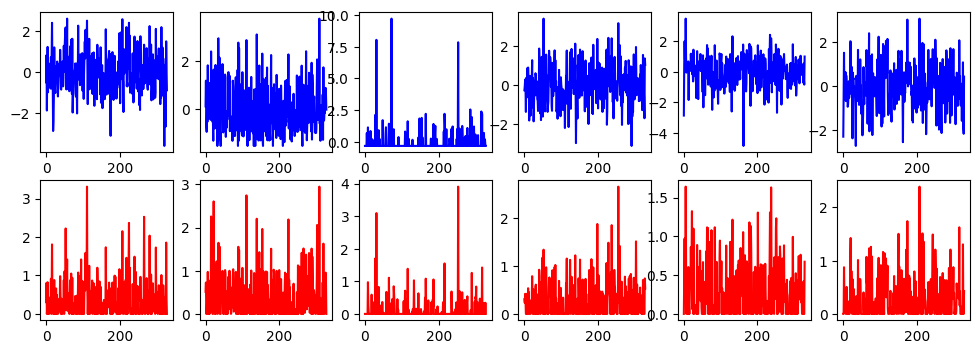

In [15]:
with torch.no_grad():
    train_enc = encoder.encode(X_train.to(device)).cpu()
    train_dec = encoder.decode(train_enc).cpu()

    train_mse = criterion(train_dec, X_train).item()
    print('MSE: {:.4f}'.format(train_mse))


fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))

for i in range(6):
    axes[0, i].plot(X_train[:, i].numpy(), color='blue')
    axes[1, i].plot(train_dec[:, i].numpy(), color='red')

plt.show()

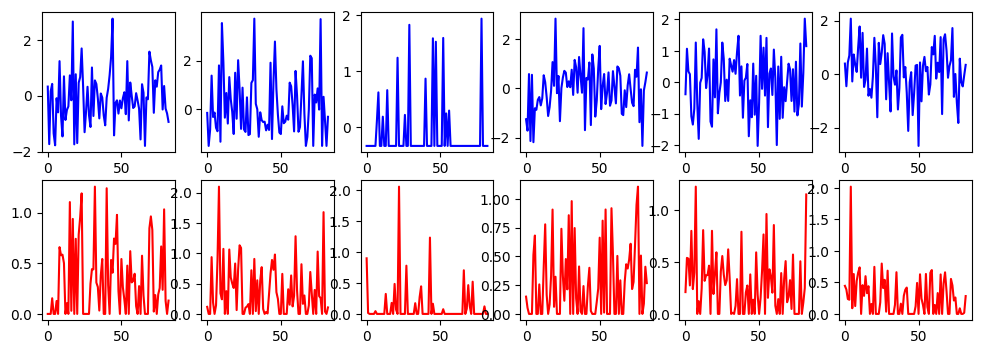

In [12]:
# randomly choose 6 features from both the original and reconstructed data
# and plot them
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))

for i in range(6):
    axes[0, i].plot(X_test[:, i].numpy(), color='blue')
    axes[1, i].plot(test_dec[:, i].numpy(), color='red')

plt.show()

In [16]:
encoder_model = {
    'encoder': encoder,
    'enc_dim': 64,
    'train_mse': 0.5633,
    'test_mse': 0.9792,
    'train_enc': train_enc,
    'test_enc': test_enc,
}

pickle.dump(encoder_model, open('/content/Assignment/Data/encoder_model.pkl', 'wb'))

In [ ]:
with torch.no_grad():
    train_enc = encoder.encode(X_train.to(device)).cpu()
    train_dec = encoder.decode(train_enc).cpu()

    mse = criterion(train_dec, X_train).item()
    print('MSE: {:.4f}'.format(mse))


fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))

for i in range(6):
    axes[0, i].plot(X_train[:, i].numpy(), color='blue')
    axes[1, i].plot(train_dec[:, i].numpy(), color='red')

plt.show()

In [18]:
pickle.dump(train_enc, open('/content/Assignment/Data/train_enc.pkl', 'wb'))
pickle.dump(test_enc, open('/content/Assignment/Data/test_enc.pkl', 'wb'))